- Summary
- Business Understanding\
   Apple looking to understand positive and negative sentiment around their products and how to improve. Focusing on neutral 
   and negative sentiment tweets as demographics to focus on.
- Data Understanding


In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
# !ls

In [3]:
df = pd.read_csv("data/tweet_product_company.csv", encoding = 'latin-1')

In [4]:
df['tweet_text_lower'] = df['tweet_text'].str.lower()

Checking if any Apple terms are in tweet_text to work with all apple related tweets since there are many missing values in
'emotion_in_tweet_is_directed_at'

In [5]:
apple_related = 'ipad|apple|iphone|itunes'

In [6]:
df['tweet_text_lower'].str.contains(apple_related).sum()

5592

In [7]:
df.shape

(9093, 4)

Dropping the one row with missing tweet_text

In [8]:
df.dropna(subset=['tweet_text'], inplace=True)

In [9]:
apple_df = df[df['tweet_text_lower'].str.contains(apple_related)].copy()

In [10]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5592 entries, 0 to 9091
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          5592 non-null   object
 1   emotion_in_tweet_is_directed_at                     2417 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  5592 non-null   object
 3   tweet_text_lower                                    5592 non-null   object
dtypes: object(4)
memory usage: 218.4+ KB


Dropping Columns 'emotion_in_tweet_is_direct_at' because we have focused on all Apple related tweets already and will analyze sentiment from there.

In [11]:
# apple_df.drop(columns=['emotion_in_tweet_is_directed_at', 'tweet_text_lower'], axis=1, inplace=True)

In [12]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5592 entries, 0 to 9091
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          5592 non-null   object
 1   emotion_in_tweet_is_directed_at                     2417 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  5592 non-null   object
 3   tweet_text_lower                                    5592 non-null   object
dtypes: object(4)
memory usage: 218.4+ KB


In [13]:
apple_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    2929
Positive emotion                      2144
Negative emotion                       420
I can't tell                            99
Name: count, dtype: int64

In [14]:
def custom_encoder(apple_df):
    apple_df.replace(to_replace ="No emotion toward brand or product", value =2, inplace=True)
    apple_df.replace(to_replace ="Positive emotion", value =1, inplace=True)
    apple_df.replace(to_replace ="Negative emotion", value =0, inplace=True)
    apple_df.replace(to_replace ="I can't tell", value =2, inplace=True)

In [15]:
custom_encoder(apple_df['is_there_an_emotion_directed_at_a_brand_or_product'])

In [16]:
apple_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tweet_text_lower
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know about @fludapp ? awesome ipad/i...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin can not wait for #ipad 2 also. the...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,@sxsw i hope this year's festival isn't as cra...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,2,@teachntech00 new ipad apps for #speechtherapy...


In [17]:
apple_df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

In [18]:
apple_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion,tweet_text_lower
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know about @fludapp ? awesome ipad/i...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin can not wait for #ipad 2 also. the...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,@sxsw i hope this year's festival isn't as cra...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,2,@teachntech00 new ipad apps for #speechtherapy...


In [19]:
apple_df.duplicated().sum()

5

In [20]:
apple_df.drop_duplicates(inplace=True)

In [21]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5587 entries, 0 to 9091
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   tweet_text                       5587 non-null   object
 1   emotion_in_tweet_is_directed_at  2412 non-null   object
 2   emotion                          5587 non-null   int64 
 3   tweet_text_lower                 5587 non-null   object
dtypes: int64(1), object(3)
memory usage: 218.2+ KB


# Train Test Split

In [22]:
from sklearn.model_selection import train_test_split

X = apple_df.drop(columns=['emotion'], axis=1)
y = apple_df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [23]:
train_sample = X_train.sample(5, random_state=42)
train_sample.style.set_properties(**{'text-align': 'left'})

,tweet_text,emotion_in_tweet_is_directed_at,tweet_text_lower
7403,#SXSW -Apple Pop-Up Store being set up right now on 6th St. My fellow truck driver is delivering the furniture NOW.,nan,#sxsw -apple pop-up store being set up right now on 6th st. my fellow truck driver is delivering the furniture now.
5609,RT @mention Check out the #dokobots game from @mention for iPhone and Android. Seems pretty cool. #geogames #SXSW #tmsxsw,iPad or iPhone App,rt @mention check out the #dokobots game from @mention for iphone and android. seems pretty cool. #geogames #sxsw #tmsxsw
8988,It's crazy here at #Apple's temporary #Austin store. Post coming up with pics. #SXSW,nan,it's crazy here at #apple's temporary #austin store. post coming up with pics. #sxsw
2394,At #SXSW conf and EVERYONE has a Mac or Ipad (including me). What happened to the PC? Is it becoming obsolete?,iPad,at #sxsw conf and everyone has a mac or ipad (including me). what happened to the pc? is it becoming obsolete?
2461,"free #iPad Lounge open daily for #SXSW serving art made on iPads, and local art, free coffee, @mention Austin Details {link} #photo",nan,"free #ipad lounge open daily for #sxsw serving art made on ipads, and local art, free coffee, @mention austin details {link} #photo"


# Wes

In [24]:
df.isnull().sum()

tweet_text                                               0
emotion_in_tweet_is_directed_at                       5801
is_there_an_emotion_directed_at_a_brand_or_product       0
tweet_text_lower                                         0
dtype: int64

- Removing one row where tweet_text is not available

In [25]:
df.dropna(subset=['tweet_text'], inplace=True)

In [26]:
df.isnull().sum()

tweet_text                                               0
emotion_in_tweet_is_directed_at                       5801
is_there_an_emotion_directed_at_a_brand_or_product       0
tweet_text_lower                                         0
dtype: int64

In [27]:
df['emotion_in_tweet_is_directed_at'].value_counts()

emotion_in_tweet_is_directed_at
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

In [28]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts() 

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

In [29]:
sample_tweets = df.sample(5, random_state=42)
sample_tweets.style.set_properties(**{'text-align': 'left'})

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tweet_text_lower
7169,Google Close to Launching New Social Network - Circles {link} #google #sxsw,nan,No emotion toward brand or product,google close to launching new social network - circles {link} #google #sxsw
2089,iPhone charging at #SXSW {link},nan,No emotion toward brand or product,iphone charging at #sxsw {link}
2303,"The walk by Lady Bird Lake was lovely, but Google Maps travel times are not to be trusted. #SXSW",Other Google product or service,Negative emotion,"the walk by lady bird lake was lovely, but google maps travel times are not to be trusted. #sxsw"
928,"ÛÏ@mention Not a rumor: Apple doing popup store in downtown Austin for #SXSW & iPad 2 launch {link} Smart move, 1of many #dfcbto",Apple,Positive emotion,"ûï@mention not a rumor: apple doing popup store in downtown austin for #sxsw & ipad 2 launch {link} smart move, 1of many #dfcbto"
5895,"RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw via @mention @mention",nan,No emotion toward brand or product,"rt @mention google to launch major new social network called circles, possibly today {link} #sxsw via @mention @mention"


- Labeling target column (is_there_an_emotion_directed_at_a_brand_or_product) 0-2:

   -0 = Negative emotion
   -1 = Positive emotion
   -2 = No emotion AND Can't tell
   

In [30]:
def custom_encoder(df):
    df.replace(to_replace ="No emotion toward brand or product", value =2, inplace=True)
    df.replace(to_replace ="Positive emotion", value =1, inplace=True)
    df.replace(to_replace ="Negative emotion", value =0, inplace=True)
    df.replace(to_replace ="I can't tell", value =2, inplace=True)

In [31]:
custom_encoder(df['is_there_an_emotion_directed_at_a_brand_or_product'])

In [32]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tweet_text_lower
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know about @fludapp ? awesome ipad/i...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin can not wait for #ipad 2 also. the...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,@sxsw i hope this year's festival isn't as cra...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,@sxtxstate great stuff on fri #sxsw: marissa m...


 - Dropping emotion_in_tweet_is_directed_at for now just to analyze tweets and overall sentiment irregardless of brand.

In [33]:
df.drop(columns=['emotion_in_tweet_is_directed_at'], inplace=True)

In [34]:
df.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product,tweet_text_lower
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1,@jessedee know about @fludapp ? awesome ipad/i...
2,@swonderlin Can not wait for #iPad 2 also. The...,1,@swonderlin can not wait for #ipad 2 also. the...
3,@sxsw I hope this year's festival isn't as cra...,0,@sxsw i hope this year's festival isn't as cra...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1,@sxtxstate great stuff on fri #sxsw: marissa m...


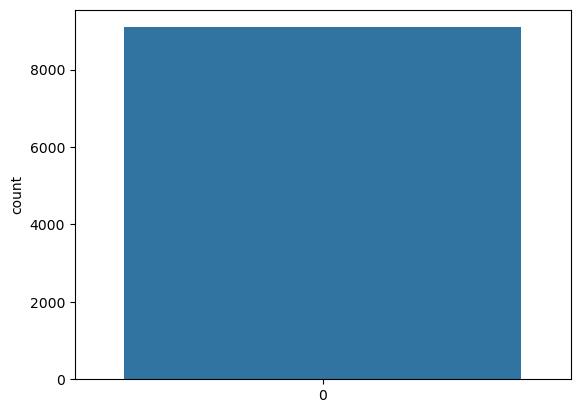

In [35]:
sns.countplot(df.is_there_an_emotion_directed_at_a_brand_or_product);

# Train test split

In [36]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['is_there_an_emotion_directed_at_a_brand_or_product'])
y = df['is_there_an_emotion_directed_at_a_brand_or_product']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [37]:
train_sample = X_train.sample(5, random_state=42)
train_sample.style.set_properties(**{'text-align': 'left'})

,tweet_text,tweet_text_lower
899,"Brilliant move by Apple: before it even begins, Apple wins #SXSW {link}","brilliant move by apple: before it even begins, apple wins #sxsw {link}"
7432,{link} Report: Apple to Open Pop-Up Store at #SXSW,{link} report: apple to open pop-up store at #sxsw
8515,omg ÛÏ@mention It's not a rumor: Apple is opening up a temporary store in downtown Austin for #SXSW and the iPad 2 launch {link},omg ûï@mention it's not a rumor: apple is opening up a temporary store in downtown austin for #sxsw and the ipad 2 launch {link}
2951,"#sxsw: @mention intrvw @mention ""Govt is not a vending machine [put in $, get svcs], it's a platform; iPhone was a teaching moment""","#sxsw: @mention intrvw @mention ""govt is not a vending machine [put in $, get svcs], it's a platform; iphone was a teaching moment"""
8963,"Group #Texting War Heats Up: Fast Society Launches New Android App, Updates iPhone App: #SXSWÛ_ {link}","group #texting war heats up: fast society launches new android app, updates iphone app: #sxswû_ {link}"


# Preprocessing

# Namsoo

## Practice : tokenization, lemmatization, word frequency

In [38]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [39]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5587 entries, 0 to 9091
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   tweet_text                       5587 non-null   object
 1   emotion_in_tweet_is_directed_at  2412 non-null   object
 2   emotion                          5587 non-null   int64 
 3   tweet_text_lower                 5587 non-null   object
dtypes: int64(1), object(3)
memory usage: 218.2+ KB


In [40]:
apple_df['tokens'] = df['tweet_text'].apply(word_tokenize)

In [41]:
apple_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion,tweet_text_lower,tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,"[., @, wesley83, I, have, a, 3G, iPhone, ., Af..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know about @fludapp ? awesome ipad/i...,"[@, jessedee, Know, about, @, fludapp, ?, Awes..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin can not wait for #ipad 2 also. the...,"[@, swonderlin, Can, not, wait, for, #, iPad, ..."
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,@sxsw i hope this year's festival isn't as cra...,"[@, sxsw, I, hope, this, year, 's, festival, i..."
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,2,@teachntech00 new ipad apps for #speechtherapy...,"[@, teachntech00, New, iPad, Apps, For, #, Spe..."


In [42]:
apple_df['tokens'] = apple_df['tokens'].apply(lambda x: [word.lower() for word in x])

In [43]:
apple_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion,tweet_text_lower,tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,"[., @, wesley83, i, have, a, 3g, iphone, ., af..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know about @fludapp ? awesome ipad/i...,"[@, jessedee, know, about, @, fludapp, ?, awes..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin can not wait for #ipad 2 also. the...,"[@, swonderlin, can, not, wait, for, #, ipad, ..."
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,@sxsw i hope this year's festival isn't as cra...,"[@, sxsw, i, hope, this, year, 's, festival, i..."
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,2,@teachntech00 new ipad apps for #speechtherapy...,"[@, teachntech00, new, ipad, apps, for, #, spe..."


In [44]:
import string
apple_df['tokens'] = apple_df['tokens'].apply(lambda x: 
                                              [word.translate(str.maketrans('', '', string.punctuation)) 
                                               for word in x])

In [45]:
apple_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion,tweet_text_lower,tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,"[, , wesley83, i, have, a, 3g, iphone, , after..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know about @fludapp ? awesome ipad/i...,"[, jessedee, know, about, , fludapp, , awesome..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin can not wait for #ipad 2 also. the...,"[, swonderlin, can, not, wait, for, , ipad, 2,..."
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,@sxsw i hope this year's festival isn't as cra...,"[, sxsw, i, hope, this, year, s, festival, is,..."
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,2,@teachntech00 new ipad apps for #speechtherapy...,"[, teachntech00, new, ipad, apps, for, , speec..."


In [46]:
stop_words = set(stopwords.words('english'))
stop_words.update(['sxsw','iphone','ipad','apple','','mention','link','rt','austin'])
apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [word for word in x if word.lower() not in stop_words])

In [47]:
stop_words = set(stopwords.words('english'))

In [48]:
type(stop_words)

set

In [49]:

stop_words.update(['sxsw','iphone','ipad','apple','','mention','link','rt','austin'])

In [50]:
# stop_words.add('link')

In [51]:
# stop_words = stop_words.append('sxsw','iphone','ipad','apple')

In [52]:
apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [word for word in x if word.lower() not in stop_words])

In [53]:
apple_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion,tweet_text_lower,tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,"[wesley83, 3g, 3, hrs, tweeting, riseaustin, d..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know about @fludapp ? awesome ipad/i...,"[jessedee, know, fludapp, awesome, ipadiphone,..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin can not wait for #ipad 2 also. the...,"[swonderlin, wait, 2, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,@sxsw i hope this year's festival isn't as cra...,"[hope, year, festival, nt, crashy, year, app]"
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,2,@teachntech00 new ipad apps for #speechtherapy...,"[teachntech00, new, apps, speechtherapy, commu..."


In [54]:
# nltk.download('wordnet')

In [55]:
lemmatizer = WordNetLemmatizer()

In [56]:
apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [lemmatizer.lemmatize(word) for word in x])

In [57]:
apple_df['tokens'].head()

0    [wesley83, 3g, 3, hr, tweeting, riseaustin, de...
1    [jessedee, know, fludapp, awesome, ipadiphone,...
2                    [swonderlin, wait, 2, also, sale]
3        [hope, year, festival, nt, crashy, year, app]
5    [teachntech00, new, apps, speechtherapy, commu...
Name: tokens, dtype: object

In [58]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5587 entries, 0 to 9091
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   tweet_text                       5587 non-null   object
 1   emotion_in_tweet_is_directed_at  2412 non-null   object
 2   emotion                          5587 non-null   int64 
 3   tweet_text_lower                 5587 non-null   object
 4   tokens                           5587 non-null   object
dtypes: int64(1), object(4)
memory usage: 261.9+ KB


### Sentiment TextBlob vs VADER

In [59]:
# pip install textblob
from textblob import TextBlob
apple_df['sentiment'] = apple_df['tweet_text'].apply(lambda x : TextBlob(x).sentiment.polarity)

In [60]:
apple_df['sentiment'].head()

0   -0.250000
1    0.466667
2   -0.155556
3    0.000000
5    0.136364
Name: sentiment, dtype: float64

### To control words in dataframes

In [152]:
# Load csv file to a DataFrame
df = pd.read_csv("data/tweet_product_company.csv", encoding = 'latin-1')
# To filter in tweets mentioning apple related products
df['tweet_text_lower'] = df['tweet_text'].str.lower()
apple_related = 'ipad|apple|iphone|itunes' # filter condition
df.dropna(subset=['tweet_text'], inplace=True) # droping out na
apple_df = df[df['tweet_text_lower'].str.contains(apple_related)].copy() # filtered
apple_df.drop_duplicates(inplace=True) # remove duplicated

# Sentiment analysis by TextBlob
# pip install textblob
from textblob import TextBlob
apple_df['sentiment'] = apple_df['tweet_text'].apply(lambda x : TextBlob(x).sentiment.polarity)

# Rename a column
apple_df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# tokenize
apple_df['tokens'] = df['tweet_text'].apply(word_tokenize)
# lowring case
apple_df['tokens'] = apple_df['tokens'].apply(lambda x: [word.lower() for word in x])
# remove punctuation
import string
apple_df['tokens'] = apple_df['tokens'].apply(lambda x: 
                                              [word.translate(str.maketrans('', '', string.punctuation)) 
                                               for word in x])




### stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['sxsw','iphone','ipad','apple','','mention','link','rt','austin','store','2','quot','popup'])
apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [word for word in x if word.lower() not in stop_words])

# lemmy
lemmatizer = WordNetLemmatizer()
apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [lemmatizer.lemmatize(word) for word in x])


In [153]:
df_pos = apple_df[apple_df['sentiment'] > 0]
df_neg = apple_df[apple_df['sentiment'] < 0]
df_neut = apple_df[apple_df['sentiment'] == 0]

### FreqDist plots

In [154]:
df_pos = apple_df[apple_df['sentiment'] > 0]
df_neg = apple_df[apple_df['sentiment'] < 0]
df_neut = apple_df[apple_df['sentiment'] == 0]

In [155]:
word_pos = nltk.FreqDist([word for tokens in df_pos['tokens'] for word in tokens])
word_neg = nltk.FreqDist([word for tokens in df_neg['tokens'] for word in tokens])
word_neut = nltk.FreqDist([word for tokens in df_neut['tokens'] for word in tokens])

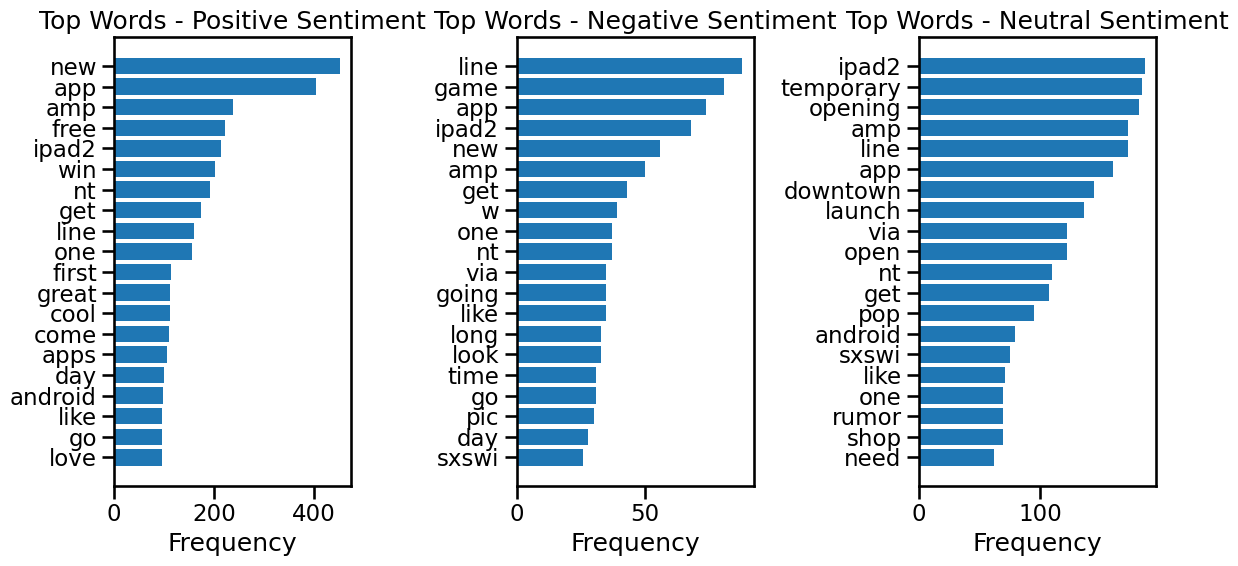

In [157]:
import matplotlib.pyplot as plt

# Assuming you have already calculated the word frequencies using nltk.FreqDist
# word_pos, word_neg, word_neut are the FreqDist objects

# Get the top N words from each FreqDist object
top_n = 20  # Number of top words to display
top_words_pos = word_pos.most_common(top_n)
top_words_neg = word_neg.most_common(top_n)
top_words_neut = word_neut.most_common(top_n)

# Extract the words and frequencies from the top word lists, and reverse the order
words_pos, freqs_pos = zip(*reversed(top_words_pos))
words_neg, freqs_neg = zip(*reversed(top_words_neg))
words_neut, freqs_neut = zip(*reversed(top_words_neut))

# Plotting the word frequencies side by side
plt.figure(figsize=(12, 6))

# Plot for positive sentiment
plt.subplot(1, 3, 1)
plt.barh(range(len(words_pos)), freqs_pos, align='center')
plt.yticks(range(len(words_pos)), words_pos)
plt.xlabel('Frequency')
plt.title('Top Words - Positive Sentiment')

# Plot for negative sentiment
plt.subplot(1, 3, 2)
plt.barh(range(len(words_neg)), freqs_neg, align='center')
plt.yticks(range(len(words_neg)), words_neg)
plt.xlabel('Frequency')
plt.title('Top Words - Negative Sentiment')

# Plot for neutral sentiment
plt.subplot(1, 3, 3)
plt.barh(range(len(words_neut)), freqs_neut, align='center')
plt.yticks(range(len(words_neut)), words_neut)
plt.xlabel('Frequency')
plt.title('Top Words - Neutral Sentiment')

plt.tight_layout()
plt.show()

### Topic Modeling with Latent Dirichlet Allocation

#### comparing number of rows of pos, neg, neut

In [76]:
df_neg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 793 entries, 0 to 9091
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   tweet_text                       793 non-null    object 
 1   emotion_in_tweet_is_directed_at  338 non-null    object 
 2   emotion                          793 non-null    int64  
 3   tweet_text_lower                 793 non-null    object 
 4   tokens                           793 non-null    object 
 5   sentiment                        793 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 43.4+ KB


In [84]:
len(df_neg)

793

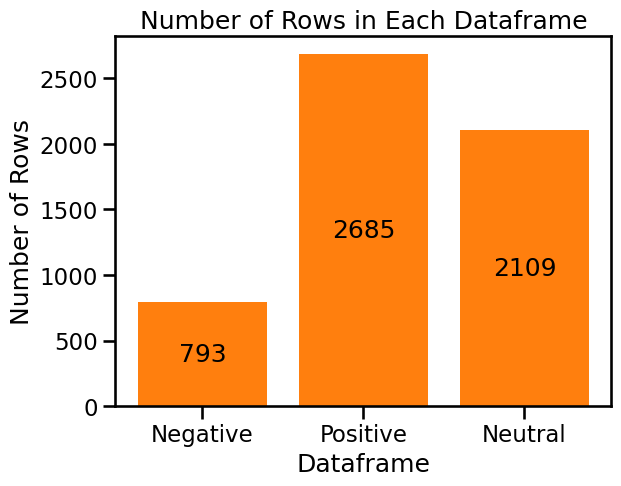

In [93]:
# Compare number of rows of each dataframes
sns.set_context('talk')
num_rows_neg = len(df_neg)
num_rows_pos = len(df_pos)
num_rows_neut = len(df_neut)

dataframe_names = ['Negative', 'Positive', 'Neutral']
row_counts = [num_rows_neg, num_rows_pos, num_rows_neut]

plt.bar(dataframe_names, row_counts)
plt.xlabel('Dataframe')
plt.ylabel('Number of Rows')
plt.title('Number of Rows in Each Dataframe')

# Add counts on top of each bar
# for i, count in enumerate(row_counts):
    # plt.text(i, count, str(count), ha='center', va='bottom')

# Add counts on top of each bar
plt.bar_label(plt.bar(dataframe_names, row_counts), fmt='%d', label_type='center')

plt.show()

In [158]:
793/(793+2685+2109)

0.14193663862538033

In [159]:
2689/(793+2685+2109)

0.4812958654018257

In [160]:
2109/(793+2685+2109)

0.37748344370860926

#### train test split and vectorizaion

In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [109]:
# Load csv file to a DataFrame
df = pd.read_csv("data/tweet_product_company.csv", encoding = 'latin-1')
# To filter in tweets mentioning apple related products
df['tweet_text_lower'] = df['tweet_text'].str.lower()
apple_related = 'ipad|apple|iphone|itunes' # filter condition
df.dropna(subset=['tweet_text'], inplace=True) # droping out na
apple_df = df[df['tweet_text_lower'].str.contains(apple_related)].copy() # filtered
apple_df.drop_duplicates(inplace=True) # remove duplicated

# Sentiment analysis by TextBlob
# pip install textblob
from textblob import TextBlob
apple_df['sentiment'] = apple_df['tweet_text'].apply(lambda x : TextBlob(x).sentiment.polarity)

# Rename a column
apple_df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# tokenize
apple_df['tokens'] = df['tweet_text'].apply(word_tokenize)
# lowring case
apple_df['tokens'] = apple_df['tokens'].apply(lambda x: [word.lower() for word in x])
# remove punctuation
import string
apple_df['tokens'] = apple_df['tokens'].apply(lambda x: 
                                              [word.translate(str.maketrans('', '', string.punctuation)) 
                                               for word in x])




### stop words
stop_words = set(stopwords.words('english'))
# stop_words.update(['sxsw','iphone','ipad','apple','','mention','link','rt','austin'])
apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [word for word in x if word.lower() not in stop_words])

# lemmy
lemmatizer = WordNetLemmatizer()
apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [lemmatizer.lemmatize(word) for word in x])


In [111]:
train_df, test_df = train_test_split(df_pos, test_size=0.2, random_state=42)

train_data = train_df['tokens'].apply(lambda tokens: ' '.join(tokens))
test_data = test_df['tokens'].apply(lambda tokens: ' '.join(tokens))

vectorizer = CountVectorizer()
train_vectorized = vectorizer.fit_transform(train_data)
test_vectorized = vectorizer.transform(test_data)

num_topics = 5  # Specify the desired number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(train_vectorized)

log_likelihood = lda.score(test_vectorized)
perplexity = lda.perplexity(test_vectorized)
print(f'Log-Likelihood: {log_likelihood}')
print(f'Perplexity: {perplexity}')

feature_names = list(vectorizer.vocabulary_.keys())
top_words = 10  # Specify the number of top words to display for each topic

for topic_idx, topic in enumerate(lda.components_):
    top_words_indices = topic.argsort()[:-top_words - 1:-1]
    top_words_list = [feature_names[i] for i in top_words_indices]
    print(f'Topic {topic_idx + 1}: {" ".join(top_words_list)}')

Log-Likelihood: -49400.66571647136
Perplexity: 2370.997109579918
Topic 1: eventseekr maven seriousness cap cheese prob technopriest irl first forbes
Topic 2: eventseekr irl maven seriousness spring tweetcaster drawing except teo wearing
Topic 3: eventseekr maven irl seriousness cheese except prob somebody loose technopriest
Topic 4: eventseekr seriousness cheese tvontheradio hmmm prob maven irl live except
Topic 5: eventseekr seriousness hmmm prob maven cheese cap irl bd technopriest


#### After updating stopwords

In [112]:
# Load csv file to a DataFrame
df = pd.read_csv("data/tweet_product_company.csv", encoding = 'latin-1')
# To filter in tweets mentioning apple related products
df['tweet_text_lower'] = df['tweet_text'].str.lower()
apple_related = 'ipad|apple|iphone|itunes' # filter condition
df.dropna(subset=['tweet_text'], inplace=True) # droping out na
apple_df = df[df['tweet_text_lower'].str.contains(apple_related)].copy() # filtered
apple_df.drop_duplicates(inplace=True) # remove duplicated

# Sentiment analysis by TextBlob
# pip install textblob
from textblob import TextBlob
apple_df['sentiment'] = apple_df['tweet_text'].apply(lambda x : TextBlob(x).sentiment.polarity)

# Rename a column
apple_df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# tokenize
apple_df['tokens'] = df['tweet_text'].apply(word_tokenize)
# lowring case
apple_df['tokens'] = apple_df['tokens'].apply(lambda x: [word.lower() for word in x])
# remove punctuation
import string
apple_df['tokens'] = apple_df['tokens'].apply(lambda x: 
                                              [word.translate(str.maketrans('', '', string.punctuation)) 
                                               for word in x])




### stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['sxsw','iphone','ipad','apple','','mention','link','rt','austin'])
apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [word for word in x if word.lower() not in stop_words])

# lemmy
lemmatizer = WordNetLemmatizer()
apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [lemmatizer.lemmatize(word) for word in x])


In [113]:
df_pos = apple_df[apple_df['sentiment'] > 0]
df_neg = apple_df[apple_df['sentiment'] < 0]
df_neut = apple_df[apple_df['sentiment'] == 0]

In [114]:
train_df, test_df = train_test_split(df_pos, test_size=0.2, random_state=42)

train_data = train_df['tokens'].apply(lambda tokens: ' '.join(tokens))
test_data = test_df['tokens'].apply(lambda tokens: ' '.join(tokens))

vectorizer = CountVectorizer()
train_vectorized = vectorizer.fit_transform(train_data)
test_vectorized = vectorizer.transform(test_data)

num_topics = 5  # Specify the desired number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(train_vectorized)

log_likelihood = lda.score(test_vectorized)
perplexity = lda.perplexity(test_vectorized)
print(f'Log-Likelihood: {log_likelihood}')
print(f'Perplexity: {perplexity}')

feature_names = list(vectorizer.vocabulary_.keys())
top_words = 10  # Specify the number of top words to display for each topic

for topic_idx, topic in enumerate(lda.components_):
    top_words_indices = topic.argsort()[:-top_words - 1:-1]
    top_words_list = [feature_names[i] for i in top_words_indices]
    print(f'Topic {topic_idx + 1}: {" ".join(top_words_list)}')

Log-Likelihood: -40836.364206959704
Perplexity: 11812.24395703759
Topic 1: mktg uberguide teletubbie tvontheradio go2 yay bob fix immersive career
Topic 2: bd nexus yay career bob cheese mktg an asd uberguide
Topic 3: yay uberguide tvontheradio wp7dev kudos loathe agreed serve retweet nexus
Topic 4: bob noniphone resource asd uberguide clean tvontheradio yay favorited mindshare
Topic 5: tvontheradio noniphone mommy yay uberguide bob diller cheese syncs announced


#### df_neg

In [118]:
# Load csv file to a DataFrame
df = pd.read_csv("data/tweet_product_company.csv", encoding = 'latin-1')
# To filter in tweets mentioning apple related products
df['tweet_text_lower'] = df['tweet_text'].str.lower()
apple_related = 'ipad|apple|iphone|itunes' # filter condition
df.dropna(subset=['tweet_text'], inplace=True) # droping out na
apple_df = df[df['tweet_text_lower'].str.contains(apple_related)].copy() # filtered
apple_df.drop_duplicates(inplace=True) # remove duplicated

# Sentiment analysis by TextBlob
# pip install textblob
from textblob import TextBlob
apple_df['sentiment'] = apple_df['tweet_text'].apply(lambda x : TextBlob(x).sentiment.polarity)

# Rename a column
apple_df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# tokenize
apple_df['tokens'] = df['tweet_text'].apply(word_tokenize)
# lowring case
apple_df['tokens'] = apple_df['tokens'].apply(lambda x: [word.lower() for word in x])
# remove punctuation
import string
apple_df['tokens'] = apple_df['tokens'].apply(lambda x: 
                                              [word.translate(str.maketrans('', '', string.punctuation)) 
                                               for word in x])




### stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['sxsw','iphone','ipad','apple','','mention','link','rt','austin'])
apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [word for word in x if word.lower() not in stop_words])

# lemmy
lemmatizer = WordNetLemmatizer()
apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [lemmatizer.lemmatize(word) for word in x])


In [119]:
df_pos = apple_df[apple_df['sentiment'] > 0]
df_neg = apple_df[apple_df['sentiment'] < 0]
df_neut = apple_df[apple_df['sentiment'] == 0]

In [120]:
train_df, test_df = train_test_split(df_neg, test_size=0.2, random_state=42)

train_data = train_df['tokens'].apply(lambda tokens: ' '.join(tokens))
test_data = test_df['tokens'].apply(lambda tokens: ' '.join(tokens))

vectorizer = CountVectorizer()
train_vectorized = vectorizer.fit_transform(train_data)
test_vectorized = vectorizer.transform(test_data)

num_topics = 5  # Specify the desired number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(train_vectorized)

log_likelihood = lda.score(test_vectorized)
perplexity = lda.perplexity(test_vectorized)
print(f'Log-Likelihood: {log_likelihood}')
print(f'Perplexity: {perplexity}')

feature_names = list(vectorizer.vocabulary_.keys())
top_words = 10  # Specify the number of top words to display for each topic

for topic_idx, topic in enumerate(lda.components_):
    top_words_indices = topic.argsort()[:-top_words - 1:-1]
    top_words_list = [feature_names[i] for i in top_words_indices]
    print(f'Topic {topic_idx + 1}: {" ".join(top_words_list)}')

Log-Likelihood: -11408.662907833655
Perplexity: 26537.289338123177
Topic 1: far peeked typing tv left ipad1 congress techcrunch demand iamagameshater
Topic 2: group saving io demand people antonio iamagameshater typing consider little
Topic 3: large group cart mindjet consider far closer friday peeked flash
Topic 4: far tv figured people living left six typing waited deep
Topic 5: far tv typing peeked ha mindjet whole left block investor


#### df_neut

In [121]:
# Load csv file to a DataFrame
df = pd.read_csv("data/tweet_product_company.csv", encoding = 'latin-1')
# To filter in tweets mentioning apple related products
df['tweet_text_lower'] = df['tweet_text'].str.lower()
apple_related = 'ipad|apple|iphone|itunes' # filter condition
df.dropna(subset=['tweet_text'], inplace=True) # droping out na
apple_df = df[df['tweet_text_lower'].str.contains(apple_related)].copy() # filtered
apple_df.drop_duplicates(inplace=True) # remove duplicated

# Sentiment analysis by TextBlob
# pip install textblob
from textblob import TextBlob
apple_df['sentiment'] = apple_df['tweet_text'].apply(lambda x : TextBlob(x).sentiment.polarity)

# Rename a column
apple_df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# tokenize
apple_df['tokens'] = df['tweet_text'].apply(word_tokenize)
# lowring case
apple_df['tokens'] = apple_df['tokens'].apply(lambda x: [word.lower() for word in x])
# remove punctuation
import string
apple_df['tokens'] = apple_df['tokens'].apply(lambda x: 
                                              [word.translate(str.maketrans('', '', string.punctuation)) 
                                               for word in x])




### stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['sxsw','iphone','ipad','apple','','mention','link','rt','austin'])
apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [word for word in x if word.lower() not in stop_words])

# lemmy
lemmatizer = WordNetLemmatizer()
apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [lemmatizer.lemmatize(word) for word in x])


In [122]:
df_pos = apple_df[apple_df['sentiment'] > 0]
df_neg = apple_df[apple_df['sentiment'] < 0]
df_neut = apple_df[apple_df['sentiment'] == 0]

In [123]:
train_df, test_df = train_test_split(df_neut, test_size=0.2, random_state=42)

train_data = train_df['tokens'].apply(lambda tokens: ' '.join(tokens))
test_data = test_df['tokens'].apply(lambda tokens: ' '.join(tokens))

vectorizer = CountVectorizer()
train_vectorized = vectorizer.fit_transform(train_data)
test_vectorized = vectorizer.transform(test_data)

num_topics = 5  # Specify the desired number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(train_vectorized)

log_likelihood = lda.score(test_vectorized)
perplexity = lda.perplexity(test_vectorized)
print(f'Log-Likelihood: {log_likelihood}')
print(f'Perplexity: {perplexity}')

feature_names = list(vectorizer.vocabulary_.keys())
top_words = 10  # Specify the number of top words to display for each topic

for topic_idx, topic in enumerate(lda.components_):
    top_words_indices = topic.argsort()[:-top_words - 1:-1]
    top_words_list = [feature_names[i] for i in top_words_indices]
    print(f'Topic {topic_idx + 1}: {" ".join(top_words_list)}')

Log-Likelihood: -24881.118440237224
Perplexity: 11029.316838718316
Topic 1: bbc prize coolest opera garage spoke virtual various check solving
Topic 2: doingitwrong prize local sunday fighting spoke coolest visa il track
Topic 3: doingitwrong prize nelson bruise ridculous coverage forgotten leanstartup mpact garage
Topic 4: boom hour check four fire guide tokyo select ubuntu truly
Topic 5: specific check served two ala coolest fashion midbattery hooker virtual


# Testing clean data from ht

In [61]:
import re
import unicodedata
from nltk.corpus import stopwords
def clean_tweet(text):
    # Remove hashtags (words starting with '#')
    text = re.sub(r'#\w+', '', text)
    
    # Handle RT tags
    text = re.sub(r'[Rr][Tt]', '', text)
    
    # Remove mentions (words starting with '@')
    text = re.sub(r'@\w+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove non-ASCII characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
        
    # Remove special characters and numbers not adjacent to text
    text = re.sub(r'\b\d+\b', '', text)

    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)     # Remove extra spaces
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_text = [word for word in text.split() if word not in stop_words]

    # Unique words to remove, add more as needed
    words_to_remove = ['Austin', 'Link', 'Sxsw', 'sxsw']

    for word in words_to_remove:
        cleaned_text = [w for w in cleaned_text if not re.match(r'\b{}\b'.format(word), w, flags=re.IGNORECASE)]

    return ' '.join(cleaned_text)

In [62]:
# Apply the clean_tweet function and see output
apple_df['cleaned_tweet'] = apple_df['tweet_text'].apply(clean_tweet)
apple_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion,tweet_text_lower,tokens,sentiment,cleaned_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,"[wesley83, 3g, 3, hr, tweeting, riseaustin, de...",-0.250000,I 3G iPhone After hrs tweeting dead I need upg...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know about @fludapp ? awesome ipad/i...,"[jessedee, know, fludapp, awesome, ipadiphone,...",0.466667,Know Awesome iPadiPhone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin can not wait for #ipad 2 also. the...,"[swonderlin, wait, 2, also, sale]",-0.155556,Can wait also They sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,@sxsw i hope this year's festival isn't as cra...,"[hope, year, festival, nt, crashy, year, app]",0.000000,I hope years festival isnt crashy years iPhone...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,2,@teachntech00 new ipad apps for #speechtherapy...,"[teachntech00, new, apps, speechtherapy, commu...",0.136364,New iPad Apps For And Communication Are Showca...


In [87]:
# Load csv file to a DataFrame
df = pd.read_csv("data/tweet_product_company.csv", encoding = 'latin-1')
# To filter in tweets mentioning apple related products
df['tweet_text_lower'] = df['tweet_text'].str.lower()
apple_related = 'ipad|apple|iphone|itunes' # filter condition
df.dropna(subset=['tweet_text'], inplace=True) # droping out na
apple_df = df[df['tweet_text_lower'].str.contains(apple_related)].copy() # filtered
apple_df.drop_duplicates(inplace=True) # remove duplicated

apple_df['tweet_text'] = apple_df['tweet_text'].apply(clean_tweet)

# Sentiment analysis by TextBlob
# pip install textblob
from textblob import TextBlob
apple_df['sentiment'] = apple_df['tweet_text'].apply(lambda x : TextBlob(x).sentiment.polarity)

# Rename a column
apple_df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# tokenize
apple_df['tokens'] = df['tweet_text'].apply(word_tokenize)
# lowring case
apple_df['tokens'] = apple_df['tokens'].apply(lambda x: [word.lower() for word in x])
# remove punctuation
import string
apple_df['tokens'] = apple_df['tokens'].apply(lambda x: 
                                              [word.translate(str.maketrans('', '', string.punctuation)) 
                                               for word in x])




### stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['sxsw','iphone','ipad','apple','','mention','link','rt','austin','store','2','quot','popup'])
apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [word for word in x if word.lower() not in stop_words])

# lemmy
lemmatizer = WordNetLemmatizer()
apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [lemmatizer.lemmatize(word) for word in x])


In [88]:
df_pos = apple_df[apple_df['sentiment'] > 0]
df_neg = apple_df[apple_df['sentiment'] < 0]
df_neut = apple_df[apple_df['sentiment'] == 0]

In [89]:
word_pos = nltk.FreqDist([word for tokens in df_pos['tokens'] for word in tokens])
word_neg = nltk.FreqDist([word for tokens in df_neg['tokens'] for word in tokens])
word_neut = nltk.FreqDist([word for tokens in df_neut['tokens'] for word in tokens])

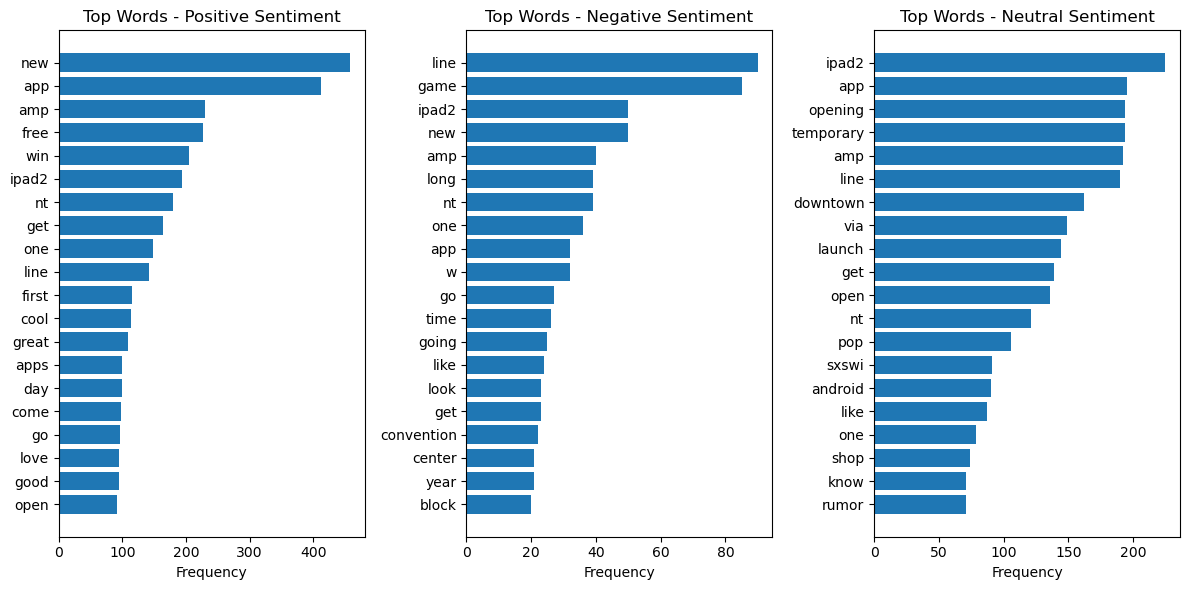

In [90]:
import matplotlib.pyplot as plt

# Assuming you have already calculated the word frequencies using nltk.FreqDist
# word_pos, word_neg, word_neut are the FreqDist objects

# Get the top N words from each FreqDist object
top_n = 20  # Number of top words to display
top_words_pos = word_pos.most_common(top_n)
top_words_neg = word_neg.most_common(top_n)
top_words_neut = word_neut.most_common(top_n)

# Extract the words and frequencies from the top word lists, and reverse the order
words_pos, freqs_pos = zip(*reversed(top_words_pos))
words_neg, freqs_neg = zip(*reversed(top_words_neg))
words_neut, freqs_neut = zip(*reversed(top_words_neut))

# Plotting the word frequencies side by side
plt.figure(figsize=(12, 6))

# Plot for positive sentiment
plt.subplot(1, 3, 1)
plt.barh(range(len(words_pos)), freqs_pos, align='center')
plt.yticks(range(len(words_pos)), words_pos)
plt.xlabel('Frequency')
plt.title('Top Words - Positive Sentiment')

# Plot for negative sentiment
plt.subplot(1, 3, 2)
plt.barh(range(len(words_neg)), freqs_neg, align='center')
plt.yticks(range(len(words_neg)), words_neg)
plt.xlabel('Frequency')
plt.title('Top Words - Negative Sentiment')

# Plot for neutral sentiment
plt.subplot(1, 3, 3)
plt.barh(range(len(words_neut)), freqs_neut, align='center')
plt.yticks(range(len(words_neut)), words_neut)
plt.xlabel('Frequency')
plt.title('Top Words - Neutral Sentiment')

plt.tight_layout()
plt.show()

In [91]:
train_df, test_df = train_test_split(df_pos, test_size=0.2, random_state=42)

train_data = train_df['tokens'].apply(lambda tokens: ' '.join(tokens))
test_data = test_df['tokens'].apply(lambda tokens: ' '.join(tokens))

vectorizer = CountVectorizer()
train_vectorized = vectorizer.fit_transform(train_data)
test_vectorized = vectorizer.transform(test_data)

num_topics = 5  # Specify the desired number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(train_vectorized)

log_likelihood = lda.score(test_vectorized)
perplexity = lda.perplexity(test_vectorized)
print(f'Log-Likelihood: {log_likelihood}')
print(f'Perplexity: {perplexity}')

feature_names = list(vectorizer.vocabulary_.keys())
top_words = 10  # Specify the number of top words to display for each topic

for topic_idx, topic in enumerate(lda.components_):
    top_words_indices = topic.argsort()[:-top_words - 1:-1]
    top_words_list = [feature_names[i] for i in top_words_indices]
    print(f'Topic {topic_idx + 1}: {" ".join(top_words_list)}')

Log-Likelihood: -37476.62478749044
Perplexity: 13617.101352545149
Topic 1: collective replacement drag everbody tronloungesxsw anything enchanting suicide pcma bubble
Topic 2: collective anything bubble mar brightness enchanting suicide vip sit launched
Topic 3: carrie mar regretting tweeted club mashabl suicide bynd 4g text
Topic 4: 4g mar conferencesevents admits showing tsotchke ui contest carrie purchased
Topic 5: mar carrie site anything msft brightness visiting dropping bart presentation


In [92]:
train_df, test_df = train_test_split(df_neg, test_size=0.2, random_state=42)

train_data = train_df['tokens'].apply(lambda tokens: ' '.join(tokens))
test_data = test_df['tokens'].apply(lambda tokens: ' '.join(tokens))

vectorizer = CountVectorizer()
train_vectorized = vectorizer.fit_transform(train_data)
test_vectorized = vectorizer.transform(test_data)

num_topics = 5  # Specify the desired number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(train_vectorized)

log_likelihood = lda.score(test_vectorized)
perplexity = lda.perplexity(test_vectorized)
print(f'Log-Likelihood: {log_likelihood}')
print(f'Perplexity: {perplexity}')

feature_names = list(vectorizer.vocabulary_.keys())
top_words = 10  # Specify the number of top words to display for each topic

for topic_idx, topic in enumerate(lda.components_):
    top_words_indices = topic.argsort()[:-top_words - 1:-1]
    top_words_list = [feature_names[i] for i in top_words_indices]
    print(f'Topic {topic_idx + 1}: {" ".join(top_words_list)}')

Log-Likelihood: -8068.561715112609
Perplexity: 67085.37699554468
Topic 1: march semi grown stole jesus min seriously handing deadline night
Topic 2: wtf lone march worst anymore min upgrade outlet played composed
Topic 3: wtf min went deadline mosaicxm tweeting packing rest reply booth
Topic 4: outlet 2011 deadline tv niceness happen wtf coming abnormal either
Topic 5: jean march outlet grown informed flip reply apple socialmedia night


In [93]:
train_df, test_df = train_test_split(df_neut, test_size=0.2, random_state=42)

train_data = train_df['tokens'].apply(lambda tokens: ' '.join(tokens))
test_data = test_df['tokens'].apply(lambda tokens: ' '.join(tokens))

vectorizer = CountVectorizer()
train_vectorized = vectorizer.fit_transform(train_data)
test_vectorized = vectorizer.transform(test_data)

num_topics = 5  # Specify the desired number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(train_vectorized)

log_likelihood = lda.score(test_vectorized)
perplexity = lda.perplexity(test_vectorized)
print(f'Log-Likelihood: {log_likelihood}')
print(f'Perplexity: {perplexity}')

feature_names = list(vectorizer.vocabulary_.keys())
top_words = 10  # Specify the number of top words to display for each topic

for topic_idx, topic in enumerate(lda.components_):
    top_words_indices = topic.argsort()[:-top_words - 1:-1]
    top_words_list = [feature_names[i] for i in top_words_indices]
    print(f'Topic {topic_idx + 1}: {" ".join(top_words_list)}')

Log-Likelihood: -28188.35337152478
Perplexity: 20878.81423906768
Topic 1: imac row suitcase tapworthy train purchaser supposedly brought trigger soldout
Topic 2: trigger tapworthy uxamandroid tuesday etsy yay fly discriminatory ii wan
Topic 3: trigger etsy echonest at038t ii tuesday tapworthy listed 141st greenberg
Topic 4: tuesday visa trigger hug twoscreen wan imac note print community
Topic 5: hi viral despite visa nutter discriminatory echonest earlier tapworthy mpact


# If I follow previous classification

In [108]:
# Load csv file to a DataFrame
df = pd.read_csv("data/tweet_product_company.csv", encoding = 'latin-1')
# To filter in tweets mentioning apple related products
# df['tweet_text_lower'] = df['tweet_text'].str.lower()
# apple_related = 'ipad|apple|iphone|itunes' # filter condition
apple_related = 'iPad|Apple|iPad or iPhone App|iPhone'
df.dropna(subset=['emotion_in_tweet_is_directed_at'], inplace=True) # droping out na
# apple_df = df[df['tweet_text_lower'].str.contains(apple_related)].copy() # filtered
apple_df = df[df['emotion_in_tweet_is_directed_at'].str.contains(apple_related)]
apple_df.drop_duplicates(inplace=True) # remove duplicated

apple_df['tweet_text'] = apple_df['tweet_text'].apply(clean_tweet)

# Sentiment analysis by TextBlob
# pip install textblob
from textblob import TextBlob
apple_df['sentiment'] = apple_df['tweet_text'].apply(lambda x : TextBlob(x).sentiment.polarity)

# Rename a column
apple_df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# tokenize
apple_df['tokens'] = df['tweet_text'].apply(word_tokenize)
# lowring case
apple_df['tokens'] = apple_df['tokens'].apply(lambda x: [word.lower() for word in x])
# remove punctuation
import string
apple_df['tokens'] = apple_df['tokens'].apply(lambda x: 
                                              [word.translate(str.maketrans('', '', string.punctuation)) 
                                               for word in x])




### stop words
stop_words = set(stopwords.words('english'))
# stop_words.update(['sxsw','iphone','ipad','apple','','mention','link','rt','austin','store','2','quot','popup'])
stop_words.update(['sxsw','','mention','link','rt','austin','store','2','quot'])

apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [word for word in x if word.lower() not in stop_words])

# lemmy
lemmatizer = WordNetLemmatizer()
apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [lemmatizer.lemmatize(word) for word in x])


/var/folders/sf/jkklx58940qbt_9v7c47hrgw0000gp/T/ipykernel_1175/4075198704.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_df.drop_duplicates(inplace=True) # remove duplicated
/var/folders/sf/jkklx58940qbt_9v7c47hrgw0000gp/T/ipykernel_1175/4075198704.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_df['tweet_text'] = apple_df['tweet_text'].apply(clean_tweet)
/var/folders/sf/jkklx58940qbt_9v7c47hrgw0000gp/T/ipykernel_1175/4075198704.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [109]:
apple_df['emotion'].value_counts()

emotion
Positive emotion                      1945
Negative emotion                       387
No emotion toward brand or product      65
I can't tell                             7
Name: count, dtype: int64

In [110]:
def custom_encoder(apple_df):
    apple_df.replace(to_replace ="No emotion toward brand or product", value =2, inplace=True)
    apple_df.replace(to_replace ="Positive emotion", value =1, inplace=True)
    apple_df.replace(to_replace ="Negative emotion", value =0, inplace=True)
    apple_df.replace(to_replace ="I can't tell", value =2, inplace=True)

In [111]:
custom_encoder(apple_df['emotion'])

/var/folders/sf/jkklx58940qbt_9v7c47hrgw0000gp/T/ipykernel_1175/644760998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_df.replace(to_replace ="No emotion toward brand or product", value =2, inplace=True)
/var/folders/sf/jkklx58940qbt_9v7c47hrgw0000gp/T/ipykernel_1175/644760998.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_df.replace(to_replace ="Positive emotion", value =1, inplace=True)
/var/folders/sf/jkklx58940qbt_9v7c47hrgw0000gp/T/ipykernel_1175/644760998.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

In [112]:
df_pos = apple_df[apple_df['emotion'] == 1]
df_neg = apple_df[apple_df['emotion'] == 0]
df_neut = apple_df[apple_df['emotion'] == 2]

In [113]:
word_pos = nltk.FreqDist([word for tokens in df_pos['tokens'] for word in tokens])
word_neg = nltk.FreqDist([word for tokens in df_neg['tokens'] for word in tokens])
word_neut = nltk.FreqDist([word for tokens in df_neut['tokens'] for word in tokens])

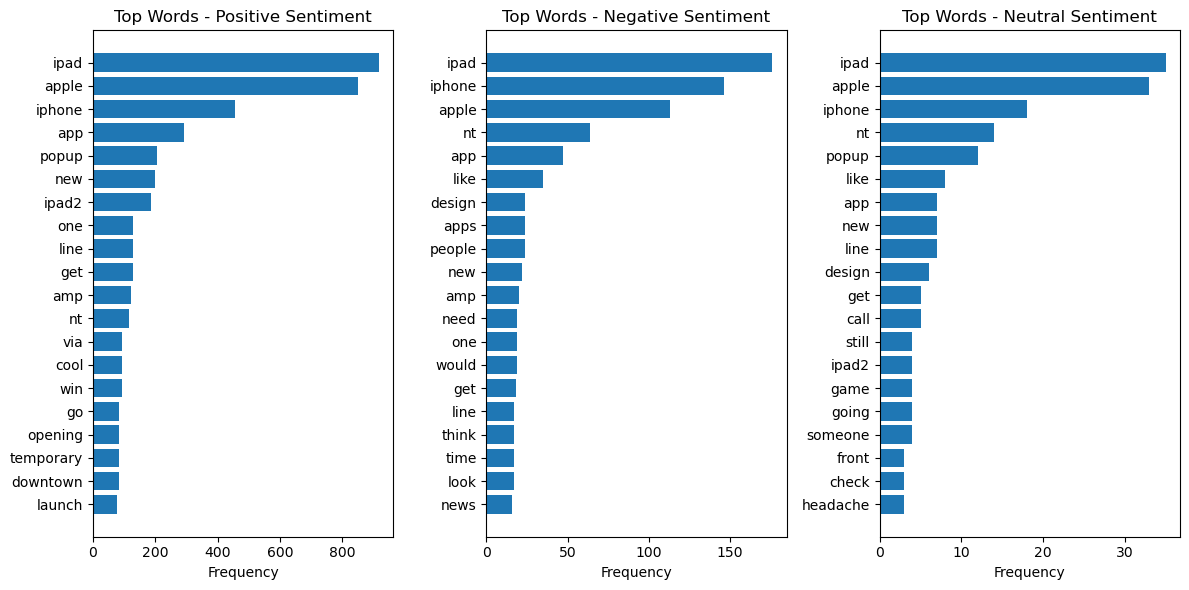

In [114]:
import matplotlib.pyplot as plt

# Assuming you have already calculated the word frequencies using nltk.FreqDist
# word_pos, word_neg, word_neut are the FreqDist objects

# Get the top N words from each FreqDist object
top_n = 20  # Number of top words to display
top_words_pos = word_pos.most_common(top_n)
top_words_neg = word_neg.most_common(top_n)
top_words_neut = word_neut.most_common(top_n)

# Extract the words and frequencies from the top word lists, and reverse the order
words_pos, freqs_pos = zip(*reversed(top_words_pos))
words_neg, freqs_neg = zip(*reversed(top_words_neg))
words_neut, freqs_neut = zip(*reversed(top_words_neut))

# Plotting the word frequencies side by side
plt.figure(figsize=(12, 6))

# Plot for positive sentiment
plt.subplot(1, 3, 1)
plt.barh(range(len(words_pos)), freqs_pos, align='center')
plt.yticks(range(len(words_pos)), words_pos)
plt.xlabel('Frequency')
plt.title('Top Words - Positive Sentiment')

# Plot for negative sentiment
plt.subplot(1, 3, 2)
plt.barh(range(len(words_neg)), freqs_neg, align='center')
plt.yticks(range(len(words_neg)), words_neg)
plt.xlabel('Frequency')
plt.title('Top Words - Negative Sentiment')

# Plot for neutral sentiment
plt.subplot(1, 3, 3)
plt.barh(range(len(words_neut)), freqs_neut, align='center')
plt.yticks(range(len(words_neut)), words_neut)
plt.xlabel('Frequency')
plt.title('Top Words - Neutral Sentiment')

plt.tight_layout()
plt.show()

In [115]:
train_df, test_df = train_test_split(df_pos, test_size=0.2, random_state=42)

train_data = train_df['tokens'].apply(lambda tokens: ' '.join(tokens))
test_data = test_df['tokens'].apply(lambda tokens: ' '.join(tokens))

vectorizer = CountVectorizer()
train_vectorized = vectorizer.fit_transform(train_data)
test_vectorized = vectorizer.transform(test_data)

num_topics = 5  # Specify the desired number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(train_vectorized)

log_likelihood = lda.score(test_vectorized)
perplexity = lda.perplexity(test_vectorized)
print(f'Log-Likelihood: {log_likelihood}')
print(f'Perplexity: {perplexity}')

feature_names = list(vectorizer.vocabulary_.keys())
top_words = 10  # Specify the number of top words to display for each topic

for topic_idx, topic in enumerate(lda.components_):
    top_words_indices = topic.argsort()[:-top_words - 1:-1]
    top_words_list = [feature_names[i] for i in top_words_indices]
    print(f'Topic {topic_idx + 1}: {" ".join(top_words_list)}')

Log-Likelihood: -28318.672793047408
Perplexity: 9871.039434979377
Topic 1: built boyfriend wipe cbatsxsw tether seat aquent 106 teach christmas
Topic 2: boyfriend tether built copia cut physical cooler lynn heart downloaded
Topic 3: boyfriend physical tether iphoneipod built wing fastsociety pump landlord perfect
Topic 4: boyfriend built tether physical pump apartment cbatsxsw crazy replacement always
Topic 5: built boyfriend tether pump physical seat wipe aquent 2seems cbatsxsw


In [116]:
train_df, test_df = train_test_split(df_neg, test_size=0.2, random_state=42)

train_data = train_df['tokens'].apply(lambda tokens: ' '.join(tokens))
test_data = test_df['tokens'].apply(lambda tokens: ' '.join(tokens))

vectorizer = CountVectorizer()
train_vectorized = vectorizer.fit_transform(train_data)
test_vectorized = vectorizer.transform(test_data)

num_topics = 5  # Specify the desired number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(train_vectorized)

log_likelihood = lda.score(test_vectorized)
perplexity = lda.perplexity(test_vectorized)
print(f'Log-Likelihood: {log_likelihood}')
print(f'Perplexity: {perplexity}')

feature_names = list(vectorizer.vocabulary_.keys())
top_words = 10  # Specify the number of top words to display for each topic

for topic_idx, topic in enumerate(lda.components_):
    top_words_indices = topic.argsort()[:-top_words - 1:-1]
    top_words_list = [feature_names[i] for i in top_words_indices]
    print(f'Topic {topic_idx + 1}: {" ".join(top_words_list)}')

Log-Likelihood: -5878.696100085457
Perplexity: 28552.63593152923
Topic 1: happen shortening many interesting crapkit unless illmakeitwork haha instagram part
Topic 2: many interesting happen part illmakeitwork know geo oldschool saw iphonebroken
Topic 3: many happen interesting using expect ridic illmakeitwork foursquaregowalla rest kinda
Topic 4: interesting many illmakeitwork shortening part nerd internet insidious want happen
Topic 5: happen many interesting struggle part illmakeitwork oldschool getting 45 useful


In [117]:
train_df, test_df = train_test_split(df_neut, test_size=0.2, random_state=42)

train_data = train_df['tokens'].apply(lambda tokens: ' '.join(tokens))
test_data = test_df['tokens'].apply(lambda tokens: ' '.join(tokens))

vectorizer = CountVectorizer()
train_vectorized = vectorizer.fit_transform(train_data)
test_vectorized = vectorizer.transform(test_data)

num_topics = 5  # Specify the desired number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(train_vectorized)

log_likelihood = lda.score(test_vectorized)
perplexity = lda.perplexity(test_vectorized)
print(f'Log-Likelihood: {log_likelihood}')
print(f'Perplexity: {perplexity}')

feature_names = list(vectorizer.vocabulary_.keys())
top_words = 10  # Specify the number of top words to display for each topic

for topic_idx, topic in enumerate(lda.components_):
    top_words_indices = topic.argsort()[:-top_words - 1:-1]
    top_words_list = [feature_names[i] for i in top_words_indices]
    print(f'Topic {topic_idx + 1}: {" ".join(top_words_list)}')

Log-Likelihood: -831.0454525963504
Perplexity: 1035875.5232425161
Topic 1: changer mscpage btw jealous gadget dying anticipation snarky brian gut
Topic 2: changer mscpage 99 gadget akqa could thank front mashable pagemaker
Topic 3: changer mscpage anticipation 99 could guy ay comment tshirt 215
Topic 4: mscpage genius everyone austinjs geez could changer packed btw disproportionately
Topic 5: mscpage could gsdm tshirt nationwide 99 changer money bitlyguardianapp best


# K means clustering

In [129]:
# Load csv file to a DataFrame
df = pd.read_csv("data/tweet_product_company.csv", encoding = 'latin-1')
# To filter in tweets mentioning apple related products
df['tweet_text_lower'] = df['tweet_text'].str.lower()
apple_related = 'ipad|apple|iphone|itunes' # filter condition
df.dropna(subset=['tweet_text'], inplace=True) # droping out na
apple_df = df[df['tweet_text_lower'].str.contains(apple_related)].copy() # filtered
apple_df.drop_duplicates(inplace=True) # remove duplicated

apple_df['tweet_text'] = apple_df['tweet_text'].apply(clean_tweet)

# Sentiment analysis by TextBlob
# pip install textblob
from textblob import TextBlob
apple_df['sentiment'] = apple_df['tweet_text'].apply(lambda x : TextBlob(x).sentiment.polarity)

# Rename a column
apple_df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# tokenize
apple_df['tokens'] = df['tweet_text'].apply(word_tokenize)
# lowring case
apple_df['tokens'] = apple_df['tokens'].apply(lambda x: [word.lower() for word in x])
# remove punctuation
import string
apple_df['tokens'] = apple_df['tokens'].apply(lambda x: 
                                              [word.translate(str.maketrans('', '', string.punctuation)) 
                                               for word in x])




### stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['sxsw','iphone','ipad','apple','','mention','link','rt','austin','store','2','quot','popup'])
apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [word for word in x if word.lower() not in stop_words])

# lemmy
lemmatizer = WordNetLemmatizer()
apple_df['tokens'] = apple_df['tokens'].apply(lambda x : [lemmatizer.lemmatize(word) for word in x])


In [130]:
df_pos = apple_df[apple_df['sentiment'] > 0]
df_neg = apple_df[apple_df['sentiment'] < 0]
df_neut = apple_df[apple_df['sentiment'] == 0]

In [131]:
df_neut.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2481 entries, 2 to 9088
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   tweet_text                       2481 non-null   object 
 1   emotion_in_tweet_is_directed_at  837 non-null    object 
 2   emotion                          2481 non-null   object 
 3   tweet_text_lower                 2481 non-null   object 
 4   sentiment                        2481 non-null   float64
 5   tokens                           2481 non-null   object 
dtypes: float64(1), object(5)
memory usage: 135.7+ KB


In [132]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [133]:
df_neut['tokens'].head()

2                        [swonderlin, wait, also, sale]
3         [hope, year, festival, nt, crashy, year, app]
16    [holler, gram, itunes, app, http, tcokfn3f5q, ...
31    [must, app, going, http, itunesapplecomusappho...
39    [vatornews, google, force, print, medium, evolve]
Name: tokens, dtype: object

In [134]:
df_neut['preprocessed_text'] = df_neut['tokens'].apply(lambda tokens: ' '.join(tokens))

/var/folders/sf/jkklx58940qbt_9v7c47hrgw0000gp/T/ipykernel_1175/3999146477.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neut['preprocessed_text'] = df_neut['tokens'].apply(lambda tokens: ' '.join(tokens))


In [135]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_neut['preprocessed_text'])

In [136]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.toarray())

# Determine the number of clusters
num_clusters = 5

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_scaled)

# Add cluster labels to the dataframe
df_neut['cluster'] = kmeans.labels_

# Analyze the clustering results
for cluster_id in range(num_clusters):
    print(f"Cluster {cluster_id}:")
    cluster_tweets = df_neut[df_neut['cluster'] == cluster_id]['tweet_text']
    print(cluster_tweets.head())
    print("------------------")

/Users/Namsoo/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0:
4005    Kenya asked blog I may tomorrow Apple popup st...
Name: tweet_text, dtype: object
------------------
Cluster 1:
2                               Can wait also They sale
3     I hope years festival isnt crashy years iPhone...
16                Holler Gram iPad iTunes App Store via
31                              You must app iPad going
39    VatorNews Google And Apple Force Print Media E...
Name: tweet_text, dtype: object
------------------
Cluster 2:
8340    taking notes Noteshelf iPad recently downloade...
Name: tweet_text, dtype: object
------------------
Cluster 3:
4557    Turn iPhone landscape web app details caridge ...
Name: tweet_text, dtype: object
------------------
Cluster 4:
7260    It dawned iPad launch timed coincide gain maxi...
Name: tweet_text, dtype: object
------------------


/var/folders/sf/jkklx58940qbt_9v7c47hrgw0000gp/T/ipykernel_1175/3389727907.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neut['cluster'] = kmeans.labels_


In [138]:
df_neut['cluster'].value_counts()

cluster
1    2477
0       1
3       1
4       1
2       1
Name: count, dtype: int64

In [ ]:
df_